<a href="https://colab.research.google.com/github/seenu-g/school_of_ai/blob/master/chap12/Trial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "Albumentation library is successfully installed!"
!pip install --no-cache-dir git+https://github.com/NVIDIA/apex > /dev/null && echo "Apex library is successfully installed!"!

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-ss8y5xzr
Albumentation library is successfully installed!
  Running command git clone -q https://github.com/NVIDIA/apex /tmp/pip-req-build-4h7kqd4w
  Running command git submodule update --init --recursive -q
Apex library is successfully installed!!


In [0]:
# mount gdrive and unzip data
from google.colab import drive
import sys
%load_ext autoreload
%autoreload 2
drive.mount('/content/gdrive',force_remount=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mounted at /content/gdrive


In [0]:
import sys
import os
folder = '/content/gdrive/My Drive/school_of_ai/chap12/'
os.chdir(folder)
print(os.getcwd()) 
text_count = 0
image_count = 0
for root, dirs,files in os.walk("."):
    for dirName in dirs :
         if((dirName !="images") & (dirName.startswith("n0")==False)) :
            print (dirName)
    for filename in files:
         if(filename.endswith(".JPEG")== True):
            image_count = image_count +1
         elif(filename.endswith(".txt")== True):
            text_count = text_count +1
         else :
            print(filename)
print ("Number of image files is ", image_count)
print ("Number of text files is ", text_count)

sys.path.append(folder)

/content/gdrive/My Drive/school_of_ai/chap12
template
tiny-imagenet-200
Trial1.ipynb
tiny-imagenet-200.zip
model.py
show_images.py
train_test.py
transforms.py
evaluate.py
__init__.py
Albumentationtransform.py
test
train
val
n12267677
Number of image files is  120000
Number of text files is  203


In [0]:
import os
import requests
from zipfile import ZipFile 
from io import StringIO

def download_images(url,fileName):
    if(os.path.isfile(fileName)==False) :
          print ('Downloading ' + url )
          try:
                r = requests.get(url, stream=True)
                with open(fileName,'wb') as f: 
                  f.write(r.content) 
          except :
                print ("Exception to download file",fileName)
                return False
    else:
        print (fileName, " already exists in ",os. getcwd()) 
    
def extract_zip_file(download_folder,fileName):
    
    if (os.path.isdir(download_folder)==False):
        print(download_folder," does not exist")
        return    
    if(os.path.isfile(fileName)==False) :
        print(fileName," from which to extract does not exist")
        return
    
    os.chdir(download_folder)
    extracted_folder = download_folder + fileName.split('.')[0]
    
    if (os.path.isdir(extracted_folder)==True):
        print ('Images seems to be downloaded and extracted already... to',extracted_folder)
        return

    with ZipFile(fileName, 'r') as zip: 
         try:
              #zip.printdir() 
              print('Extracting file ' + fileName + ' now... to ',extracted_folder) 
              zip.extractall() 
              print('File Extraction Done!') 
              return 
         except:
              print ("Exception to Unzip file",fileName)
              return 

In [0]:
IMAGES_URL = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
fileName = "tiny-imagenet-200.zip"
download_folder = folder

#download_images(IMAGES_URL,fileName)
extract_zip_file(download_folder,fileName)

Images seems to be downloaded and extracted already... to /content/gdrive/My Drive/school_of_ai/chap12/tiny-imagenet-200


In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.image as mpimg

NUM_VAL_IMAGES = 10000
BATCH_SIZE = 20
NUM_CLASSES = 200
NUM_IMAGES_PER_CLASS = 500
NUM_IMAGES = NUM_CLASSES * NUM_IMAGES_PER_CLASS
IMAGE_SIZE = 64
NUM_CHANNELS = 3
IMAGE_ARR_SIZE = IMAGE_SIZE * IMAGE_SIZE * NUM_CHANNELS

#train
#--- n01443537{type}
#    --- images
#       ---n01443537_0.JPEG
#    --- n01443537_boxes.txt
def load_training_images(train_image_dir, batch_size=500):
    image_index = 0
    images = np.ndarray(shape=(NUM_IMAGES, IMAGE_ARR_SIZE))
    names = []
    labels = []                           
    for type in os.listdir(train_image_dir):
        # Loop through all type name that are folder names
        if os.path.isdir(train_image_dir + type + '/images/'):
            type_images = os.listdir(train_image_dir + type + '/images/')
            # Loop through all the images of a type folder
            batch_index = 0
            for image in type_images:
                train_image_file = os.path.join(train_image_dir, type + '/images/', image)
                image_data = mpimg.imread(train_image_file) 
                #print ('Loaded Image', image_file, image_data.shape)
                if (image_data.shape == (IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)):
                    images[image_index, :] = image_data.flatten()

                    labels.append(type)
                    names.append(image)
                    
                    image_index += 1
                    batch_index += 1
                    
                if (batch_index >= batch_size):
                    break
   
    print ("Loaded Training images ", image_index)  #20 * 200 #batch_size * class_count          
    return (images, np.asarray(labels), np.asarray(names))

def get_label_from_name(data, name):
    for idx, row in data.iterrows():       
        if (row['File'] == name):
            return row['Class']       
    return None
#val
#  --- images
#       ---n01443537_0.JPEG
#  --- val_annotations.txt
def load_validation_images(valdir, validation_data, batch_size=NUM_VAL_IMAGES):
    image_index = 0
    images = np.ndarray(shape=(NUM_IMAGES, IMAGE_ARR_SIZE))
    names = []
    labels = []      
           
    # Loop through all the images of a val directory
    batch_index = 0
    for image in os.listdir(valdir + '/images/'):
        image_file = os.path.join(valdir, 'images/', image)
        # reading the images as they are; no normalization, no color editing
        image_data = mpimg.imread(image_file) 
        if (image_data.shape == (IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)):
            images[image_index, :] = image_data.flatten()
            labels.append(get_label_from_name(validation_data, image))
            names.append(image)
            image_index += 1
            batch_index += 1
            
        if (batch_index >= batch_size):
            break
    
    print ("Loaded Validation images ", image_index)
    return (images, np.asarray(labels), np.asarray(names))

def read_val_annotations(dirName, fileName) :
  val_data = pd.read_csv(dirName + fileName, sep='\t', header=None, names=['File', 'Class', '1', '2', '3', '4'])
  return val_data

In [0]:
TRAINING_IMAGES_DIR = 'tiny-imagenet-200/train/'
VAL_IMAGES_DIR = 'tiny-imagenet-200/val/'
extracted_folder = folder + "tiny-imagenet-200/"
base_folder = folder

train_images, train_labels, train_files = load_training_images(base_folder + TRAINING_IMAGES_DIR, batch_size=BATCH_SIZE)
val_data = read_val_annotations(VAL_IMAGES_DIR,'val_annotations.txt')
val_images, val_labels, val_files = load_validation_images(base_folder + VAL_IMAGES_DIR, val_data, batch_size=BATCH_SIZE)

Loaded Training images  4000
Loaded Validation images  20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


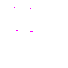

In [0]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
def plot_object(data):
    plt.figure(figsize=(1,1))
    image = data.reshape(IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
    plt.imshow(image, cmap = matplotlib.cm.binary,interpolation="nearest")
    plt.axis("off")
    plt.show()

plot_object(train_images[5])